# Pre-processing of GLAMOS MB data:

## Setting up:

In [2]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from scipy.spatial.distance import cdist
import pyproj
import matplotlib.pyplot as plt
from scripts.helpers import *
from scripts.glamos_preprocess import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## 1. Transform .dat files to .csv:

In [2]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_mb_a, glamosfiles_mb_w = [], []
for file in os.listdir(path_PMB_GLAMOS_a_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_PMB_GLAMOS_a_raw, file)):
        glamosfiles_mb_a.append(file)

for file in os.listdir(path_PMB_GLAMOS_w_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_PMB_GLAMOS_w_raw, file)):
        glamosfiles_mb_w.append(file)

print('Examples of index stake raw files:\n', glamosfiles_mb_a[:5])

# Transform all files to csv
RUN = True
if RUN:
    emptyfolder(path_PMB_GLAMOS_csv_a)
    emptyfolder(path_PMB_GLAMOS_csv_w)
    for file in glamosfiles_mb_a:
        fileName = re.split('.dat', file)[0]
        processDatFile(fileName, path_PMB_GLAMOS_a_raw, path_PMB_GLAMOS_csv_a)

    for file in glamosfiles_mb_w:
        fileName = re.split('.dat', file)[0]
        processDatFile(fileName, path_PMB_GLAMOS_w_raw, path_PMB_GLAMOS_csv_w)

    # Separate clariden into clariden II and III
    fileName = 'clariden_annual.csv'
    clariden_csv_a = pd.read_csv(path_PMB_GLAMOS_csv_a + fileName,
                                 sep=',',
                                 header=0,
                                 encoding='latin-1')
    clariden_csv_a[clariden_csv_a['# name'] == 'L'].to_csv(
        path_PMB_GLAMOS_csv_a + 'claridenL_annual.csv', index=False)
    clariden_csv_a[clariden_csv_a['# name'] == 'U'].to_csv(
        path_PMB_GLAMOS_csv_a + 'claridenU_annual.csv', index=False)

    fileName = 'clariden_winter.csv'
    clariden_csv_w = pd.read_csv(path_PMB_GLAMOS_csv_w + fileName,
                                 sep=',',
                                 header=0,
                                 encoding='latin-1')
    clariden_csv_w[clariden_csv_w['# name'] == 'L'].to_csv(
        path_PMB_GLAMOS_csv_w + 'claridenL_winter.csv', index=False)
    clariden_csv_w[clariden_csv_w['# name'] == 'U'].to_csv(
        path_PMB_GLAMOS_csv_w + 'claridenU_winter.csv', index=False)

    os.remove(path_PMB_GLAMOS_csv_a + 'clariden_annual.csv')
    os.remove(path_PMB_GLAMOS_csv_w + 'clariden_winter.csv')

# Example:
fileName = 'aletsch_annual.csv'
aletsch_csv = pd.read_csv(path_PMB_GLAMOS_csv_a + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

Examples of index stake raw files:
 ['tortin_annual.dat', 'forno_annual.dat', 'rosatsch_annual.dat', 'petitplanneve_annual.dat', 'corvatsch_annual.dat']


,# name,date0,time0,date1,time1,period,date_quality,x_pos,y_pos,z_pos,...,density,density_quality,mb_we,measurement_quality,measurement_type,mb_error,reading_error,density_error,error_evaluation_method,source
0,NMF,19120909,1200,19130920,1200,376.0,0,647166.0,150081.0,2850.0,...,700,4,-1120,2,6,1094,1085,134,0,glrep
1,NMG1,19120924,1200,19130920,1200,361.0,0,647089.0,150780.0,2802.0,...,539,6,592,4,6,873,870,71,0,glrep


##  2. Measurement periods:
### 2.1. Annual measurements: 
Process annual measurements and put all stakes into one csv file

In [3]:
# Assemble all into one csv file:
RUN = True
if RUN:
    # Annual:
    df_annual_raw = pd.DataFrame()
    for file in tqdm(os.listdir(path_PMB_GLAMOS_csv_a), desc='Annual stakes'):
        fileName = re.split('.csv', file)[0]
        glacierName = re.split('_', fileName)[0]
        df = pd.read_csv(path_PMB_GLAMOS_csv_a + file,
                         sep=',',
                         header=0,
                         encoding='latin-1')
        df['glacier'] = glacierName
        df['period'] = 'annual'

        # Correct years and add hydrol. year:
        df_processed = transformDates(df)

        # Remove obvious duplicates:
        df_processed = df_processed.drop_duplicates()

        # Transform to lat/lon system
        df_processed = LV03toWGS84(df_processed)

        df_annual_raw = pd.concat([df_annual_raw, df_processed])

    # Get the year:
    df_annual_raw['YEAR'] = df_annual_raw['date1'].apply(
        lambda x: pd.to_datetime(x).year)

# Reshape to WGMS format:
# re-order columns:
df_annual_raw = df_annual_raw[[
    'YEAR', '# name', 'glacier', 'date0', 'date1', 'lat', 'lon', 'height',
    'mb_we', 'period', 'date_fix0', 'date_fix1', 'time0', 'time1',
    'date_quality', 'position_quality', 'mb_raw', 'density', 'density_quality',
    'measurement_quality', 'measurement_type', 'mb_error', 'reading_error',
    'density_error', 'error_evaluation_method', 'source'
]]
df_annual_raw.rename(columns={
    '# name': 'POINT_ID',
    'lat': 'POINT_LAT',
    'lon': 'POINT_LON',
    'height': 'POINT_ELEVATION',
    'date0': 'FROM_DATE',
    'date1': 'TO_DATE',
    'mb_we': 'POINT_BALANCE',
    'glacier': 'GLACIER',
    'period': 'PERIOD'
},
                     inplace=True)
# remove duplicates:
df_annual_raw = df_annual_raw.drop_duplicates()
df_annual_raw.head(2)

Annual stakes:   0%|          | 0/57 [00:00<?, ?it/s]

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,mb_raw,density,density_quality,measurement_quality,measurement_type,mb_error,reading_error,density_error,error_evaluation_method,source
0,2003,01,oberaar,20021006,20031011,46.538806,8.233237,2389.812633,-6174,annual,...,-686,900,1,1,1,102,45,92,0,hm
1,2003,02,oberaar,20021006,20031011,46.536611,8.225514,2499.825727,-5310,annual,...,-590,900,1,1,1,91,45,79,0,hm


In [4]:
# verify that to_date is always from_date year + 1
# drop rows where this is not the case:
rows_to_drop = []
for i, row in df_annual_raw.iterrows():
    if pd.to_datetime(row['TO_DATE'], format = '%Y%m%d').year - pd.to_datetime(
            row['FROM_DATE'], format = '%Y%m%d').year != 1:
        # print(row['FROM_DATE'], row['TO_DATE'])
        # drop row:
        rows_to_drop.append(i)
df_annual_raw.drop(rows_to_drop, inplace=True)

### 2.2. Winter measurements:
For each point in annual meas., take winter meas that was taken closest:

In [5]:
winter_glaciers = [
    re.split('_winter.csv', f)[0] for f in os.listdir(path_PMB_GLAMOS_csv_w)
]
RUN = False
if RUN:
    emptyfolder(path_PMB_GLAMOS_csv_w_clean)
    for glacier in tqdm(df_annual_raw.GLACIER.unique(),
                        desc='Glaciers',
                        leave=False,
                        position=0):
        # If glacier does not have winter measurements:
        if glacier not in winter_glaciers:
            continue

        # Get winter all PMB measurements (a lot more than annual)
        df_winter = pd.read_csv(path_PMB_GLAMOS_csv_w + glacier +
                                '_winter.csv',
                                sep=',',
                                header=0,
                                encoding='latin-1')
        df_winter['period'] = 'winter'
        df_winter['glacier'] = glacier

        # Correct years and add hydrol. year:
        df_winter = transformDates(df_winter)

        # Remove obvious duplicates:
        df_winter = df_winter.drop_duplicates()

        # Transform to lat/lon system
        df_winter = LV03toWGS84(df_winter)

        # Add the year:
        df_winter['YEAR'] = df_winter['date1'].apply(
            lambda x: pd.to_datetime(x).year)

        # Reshape to WGMS format:
        df_winter.rename(columns={
            '# name': 'POINT_ID',
            'lat': 'POINT_LAT',
            'lon': 'POINT_LON',
            'height': 'POINT_ELEVATION',
            'date0': 'FROM_DATE',
            'date1': 'TO_DATE',
            'mb_we': 'POINT_BALANCE',
            'glacier': 'GLACIER',
            'period': 'PERIOD'
        },
                         inplace=True)
        # re-order columns:
        df_winter = df_winter[[
            'YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
            'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD',
            'date_fix0', 'date_fix1', 'time0', 'time1', 'date_quality',
            'position_quality', 'mb_raw', 'density', 'density_quality',
            'measurement_quality', 'measurement_type', 'mb_error',
            'reading_error', 'density_error', 'error_evaluation_method',
            'source'
        ]]

        winter_indices = []
        # Iterate over all rows in annual stakes:
        for index in tqdm(range(
                len(df_annual_raw[df_annual_raw.GLACIER == glacier])),
                          desc='rows',
                          leave=False,
                          position=1):
            pointA = df_annual_raw[df_annual_raw.GLACIER ==
                                   glacier].iloc[index]
            yearA = pointA.YEAR

            # Filter winter to same year as point:
            df_winter_year = df_winter[df_winter.YEAR == yearA]

            # If no winter measurement was taken that year:
            if len(df_winter_year) == 0:
                continue

            # Calculate closest winter point to annual stake:
            df_winter_year['point'] = [(x, y) for x, y in zip(
                df_winter_year['POINT_LAT'], df_winter_year['POINT_LON'])]
            pointA['point'] = (pointA.POINT_LAT, pointA.POINT_LON)
            closest = closest_point(pointA['point'],
                                    list(df_winter_year['point']))

            # Convert to LAEA Europe
            x_laea, y_laea = latlon_to_laea(closest[0], closest[1])
            x_laea_point, y_laea_point = latlon_to_laea(
                pointA.POINT_LAT, pointA.POINT_LON)

            # Calculate distance:
            distance_m = np.sqrt((x_laea_point - x_laea)**2 +
                                 (y_laea_point - y_laea)**2)

            # Only keep winter stakes that are within 10m:
            if distance_m > 10:
                continue
            else:
                winter_indices.append(df_winter_year[df_winter_year['point'] ==
                                                     closest].index[0])

        # Save winter stake:
        df_winter_stakes = df_winter.iloc[winter_indices]
        df_winter_stakes.to_csv(path_PMB_GLAMOS_csv_w_clean + glacier +
                                '_winter.csv')

### 2.3. Assemble both periods:

In [6]:
df_all_raw = df_annual_raw.copy()
for file in os.listdir(path_PMB_GLAMOS_csv_w_clean):
    fileName = re.split('.csv', file)[0]
    glacierName = re.split('_', fileName)[0]
    df_winter = pd.read_csv(path_PMB_GLAMOS_csv_w_clean + file,
                            sep=',',
                            header=0,
                            encoding='latin-1').drop(columns='Unnamed: 0')

    df_all_raw = pd.concat([df_all_raw, df_winter])

print('Number of winter and annual samples:', len(df_all_raw))
print('Number of winter samples:',
      len(df_all_raw[df_all_raw.PERIOD == 'winter']))
print('Number of annual samples:',
      len(df_all_raw[df_all_raw.PERIOD == 'annual']))

# download all stakes coordinates:
# df_all_raw[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
#             'PERIOD']].to_csv(path_PMB_GLAMOS_csv + 'coordinates_all.csv')

# Save all stakes:
df_all_raw.to_csv(path_PMB_GLAMOS_csv + 'df_all_raw.csv')

Number of winter and annual samples: 12656
Number of winter samples: 2350
Number of annual samples: 10306


In [7]:
for i, row in df_all_raw.iterrows():
    if pd.to_datetime(row['TO_DATE'], format='%Y%m%d').year - pd.to_datetime(
            row['FROM_DATE'], format='%Y%m%d').year != 1:
        print(row['GLACIER'], row['FROM_DATE'],
              pd.to_datetime(row['FROM_DATE'], format='%Y%m%d').year,
              row['TO_DATE'],
              pd.to_datetime(row['TO_DATE'], format='%Y%m%d').year)

schwarzberg 19560501 1956 19560501 1956
schwarzberg 19570501 1957 19570501 1957
schwarzberg 19580501 1958 19580501 1958
schwarzberg 19590501 1959 19590501 1959
schwarzberg 19600501 1960 19600501 1960
schwarzberg 19610503 1961 19610503 1961
schwarzberg 19610503 1961 19610503 1961
schwarzberg 19610503 1961 19610503 1961
schwarzberg 19610503 1961 19610503 1961
schwarzberg 19610503 1961 19610503 1961
schwarzberg 19610503 1961 19610503 1961
schwarzberg 19620426 1962 19620426 1962
schwarzberg 19620426 1962 19620426 1962
schwarzberg 19620426 1962 19620426 1962
schwarzberg 19620426 1962 19620426 1962
schwarzberg 19620426 1962 19620426 1962
schwarzberg 19620426 1962 19620426 1962
schwarzberg 19630501 1963 19630501 1963
schwarzberg 19630501 1963 19630501 1963
schwarzberg 19630501 1963 19630501 1963
schwarzberg 19630501 1963 19630501 1963
schwarzberg 19630501 1963 19630501 1963
schwarzberg 19630501 1963 19630501 1963
schwarzberg 19640510 1964 19640510 1964
schwarzberg 19640510 1964 19640510 1964


## 3. Add RGIs Ids:

In [10]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
rgi_df.head(2)

,full_name,sgi-id,rgi_id.v6,rgi_id.v7,Issue
short_name,,,,,
adler,Adler,B56/03,RGI60-11.02764,RGI2000-v7.0-G-11-01075,False
albigna,Albigna,NaN,RGI60-11.02285,RGI2000-v7.0-G-11-02309,True


In [9]:
# Keep important features:
df_all_raw = pd.read_csv(path_PMB_GLAMOS_csv + 'df_all_raw.csv',
                         sep=',',
                         header=0,
                         encoding='latin-1').drop(columns='Unnamed: 0')
df_pmb = df_all_raw[[
    'YEAR',
    'POINT_ID',
    'GLACIER',
    'FROM_DATE',
    'TO_DATE',
    'POINT_LAT',
    'POINT_LON',
    'POINT_ELEVATION',
    'POINT_BALANCE',
    'PERIOD',
]]
df_pmb.head(3)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD
0,2003,01,oberaar,20021006,20031011,46.538806,8.233237,2389.812633,-6174,annual
1,2003,02,oberaar,20021006,20031011,46.536611,8.225514,2499.825727,-5310,annual
2,2003,03,oberaar,20021006,20031011,46.532136,8.207734,2679.854419,-4320,annual


In [10]:
# Add RGIs:
# Specify the shape filename of the glaciers outline obtained from RGIv6
glacier_outline_fname = '../../../data/GLAMOS/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp'

# Load the target data and the glacier outlines
glacier_outline = gpd.read_file(glacier_outline_fname)

# Add RGI IDs through intersection with shapefiles:
df_pmb = mbm.utils.get_rgi(data=df_pmb, glacier_outlines=glacier_outline)

# Add RGIs without intersections (by finding the closest polygon):
# for points where polygon intersection is NaN (about a 1000)
no_match_df = df_pmb[df_pmb.RGIId.isna()]
geometry = [
    Point(lon, lat)
    for lon, lat in zip(no_match_df["POINT_LON"], no_match_df["POINT_LAT"])
]
points_gdf = gpd.GeoDataFrame(no_match_df,
                              geometry=geometry,
                              crs=glacier_outline.crs)
for index in tqdm(no_match_df.index):
    point = points_gdf.loc[index]['geometry']
    polygon_index = glacier_outline.distance(point).sort_values().index[0]
    closest_rgi = glacier_outline.loc[polygon_index].RGIId
    df_pmb.at[index, 'RGIId'] = closest_rgi

  0%|          | 0/1411 [00:00<?, ?it/s]

In [11]:
# Look at identified RGIs per glacier:
rgiids6 = df_pmb[['GLACIER',
                  'RGIId']].sort_values(by='GLACIER').drop_duplicates()
rgis = {}
for gl in rgiids6.GLACIER.unique():
    rgis[gl] = list(rgiids6[rgiids6.GLACIER == gl].RGIId)
rgis

{'adler': ['RGI60-11.02764'],
 'albigna': ['RGI60-11.02285', 'RGI60-11.02299', 'RGI60-11.02282'],
 'aletsch': ['RGI60-11.01450'],
 'allalin': ['RGI60-11.02704'],
 'arolla': ['RGI60-11.02810'],
 'basodino': ['RGI60-11.01987'],
 'bertol': ['RGI60-11.02779'],
 'blauschnee': ['RGI60-11.00638'],
 'cantun': ['RGI60-11.02268'],
 'chessjen': ['RGI60-11.02674'],
 'claridenL': ['RGI60-11.00817'],
 'claridenU': ['RGI60-11.00843'],
 'corbassiere': ['RGI60-11.02766'],
 'corvatsch': ['RGI60-11.01962'],
 'damma': ['RGI60-11.01246'],
 'diablerets': ['RGI60-11.02261'],
 'diavolezza': ['RGI60-11.02013'],
 'err': ['RGI60-11.01516', 'RGI60-11.01549'],
 'findelen': ['RGI60-11.02773'],
 'forno': ['RGI60-11.02245'],
 'gietro': ['RGI60-11.02774'],
 'gorner': ['RGI60-11.02822'],
 'gries': ['RGI60-11.01876', 'RGI60-11.02441'],
 'gurschen': ['RGI60-11.01344'],
 'hohlaub': ['RGI60-11.02679'],
 'joeri': ['RGI60-11.01063'],
 'limmern': ['RGI60-11.00918', 'RGI60-11.00915'],
 'misaun': ['RGI60-11.01945'],
 'morterats

In [12]:
# Manual pre-processing and removal of errors:
# Silvretta: weird outlier coordinate
df_pmb_clean = df_pmb.copy()
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'silvretta')
                             & (df_pmb_clean.POINT_LAT > 46.9)].index
df_pmb_clean.drop(index_outlier, inplace=True)

# and remove the stake that is on the neighbouring glacier:
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'silvretta')
                             & (df_pmb_clean.RGIId != 'RGI60-11.00804')].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Albigna: different rgis, remove stakes that are for two neighbouring glaciers:
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'albigna')
                             & (df_pmb_clean.RGIId != 'RGI60-11.02285')].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Err glacier: remove stakes that are on neighbouring glacier:
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'err')
                             & (df_pmb_clean.RGIId != 'RGI60-11.01516')].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Gries: weird outlier coordinate
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'gries')
                             & (df_pmb_clean.RGIId != 'RGI60-11.01876')].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Limmern: three stakes on neighbouring glacier
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'limmern')
                             & (df_pmb_clean.RGIId != 'RGI60-11.00918')].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Offental: on no RGI v6 outline
df_pmb_clean = df_pmb_clean[df_pmb_clean.GLACIER != 'ofental']

# Orny: change to correct RGIId
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'orny')].index
for i in index_outlier:
    df_pmb_clean.at[i, 'RGIId'] = 'RGI60-11.02775'

# Plattalva: change to correct RGIId
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'plattalva')].index
for i in index_outlier:
    df_pmb_clean.at[i, 'RGIId'] = 'RGI60-11.00892'

# Rhone outliers outside of RGI:
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'rhone')
                             & (df_pmb_clean.POINT_LAT < 46.58)].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Look at identified RGIs per glacier:
rgiids6 = df_pmb_clean[['GLACIER',
                        'RGIId']].sort_values(by='GLACIER').drop_duplicates()
rgis = {}
for gl in rgiids6.GLACIER.unique():
    rgis[gl] = list(rgiids6[rgiids6.GLACIER == gl].RGIId)
print('RGIs after pre-processing:')
rgis

RGIs after pre-processing:


{'adler': ['RGI60-11.02764'],
 'albigna': ['RGI60-11.02285'],
 'aletsch': ['RGI60-11.01450'],
 'allalin': ['RGI60-11.02704'],
 'arolla': ['RGI60-11.02810'],
 'basodino': ['RGI60-11.01987'],
 'bertol': ['RGI60-11.02779'],
 'blauschnee': ['RGI60-11.00638'],
 'cantun': ['RGI60-11.02268'],
 'chessjen': ['RGI60-11.02674'],
 'claridenL': ['RGI60-11.00817'],
 'claridenU': ['RGI60-11.00843'],
 'corbassiere': ['RGI60-11.02766'],
 'corvatsch': ['RGI60-11.01962'],
 'damma': ['RGI60-11.01246'],
 'diablerets': ['RGI60-11.02261'],
 'diavolezza': ['RGI60-11.02013'],
 'err': ['RGI60-11.01516'],
 'findelen': ['RGI60-11.02773'],
 'forno': ['RGI60-11.02245'],
 'gietro': ['RGI60-11.02774'],
 'gorner': ['RGI60-11.02822'],
 'gries': ['RGI60-11.01876'],
 'gurschen': ['RGI60-11.01344'],
 'hohlaub': ['RGI60-11.02679'],
 'joeri': ['RGI60-11.01063'],
 'limmern': ['RGI60-11.00918'],
 'misaun': ['RGI60-11.01945'],
 'morteratsch': ['RGI60-11.01946'],
 'murtel': ['RGI60-11.02024'],
 'oberaar': ['RGI60-11.01509'],
 '

In [13]:
# save to csv:
df_pmb_clean.to_csv(path_PMB_GLAMOS_csv + 'df_pmb_all.csv')

## 5. Cut from 1961:

In [14]:
# Filter to start of MS data (1961) or ERA5-Land data (1950):
df_pmb_60s = df_pmb_clean[df_pmb_clean.YEAR > 1960].sort_values(
    by=['GLACIER', 'YEAR'], ascending=[True, True])
print('Number of winter and annual samples:', len(df_pmb_60s))
print('Number of annual samples:',
      len(df_pmb_60s[df_pmb_60s.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_60s[df_pmb_60s.PERIOD == 'winter']))

Number of winter and annual samples: 10666
Number of annual samples: 8811
Number of winter samples: 1855


Text(0.5, 1.0, 'Number of total measurements per year since 1961')

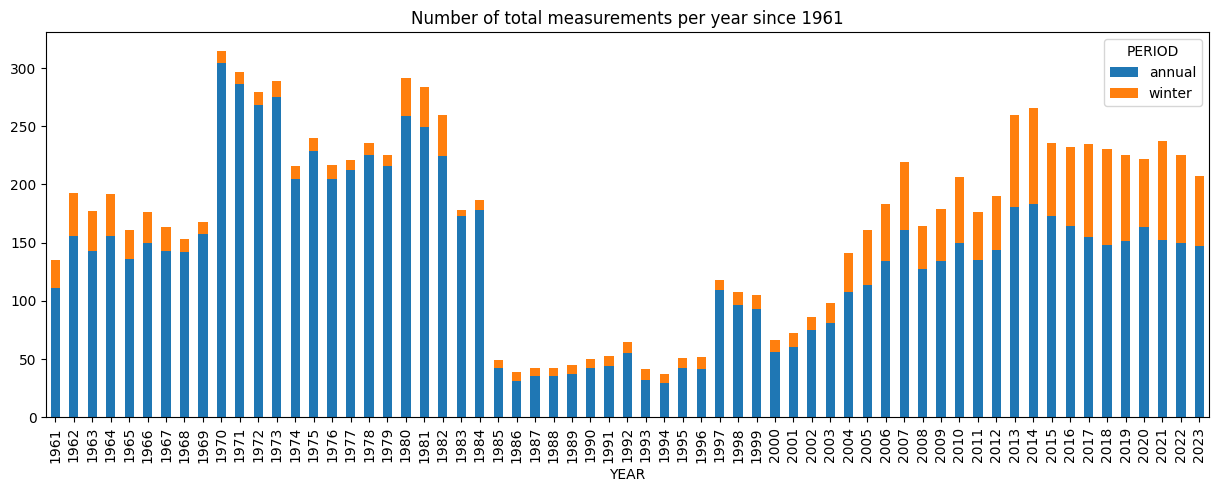

In [15]:
# Number of measurements per year:
df_pmb_60s.groupby(['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                                             stacked=True,
                                                             figsize=(15, 5))
plt.title('Number of total measurements per year since 1961')

Text(0.5, 1.0, 'Number of total measurements per glacier since 1961')

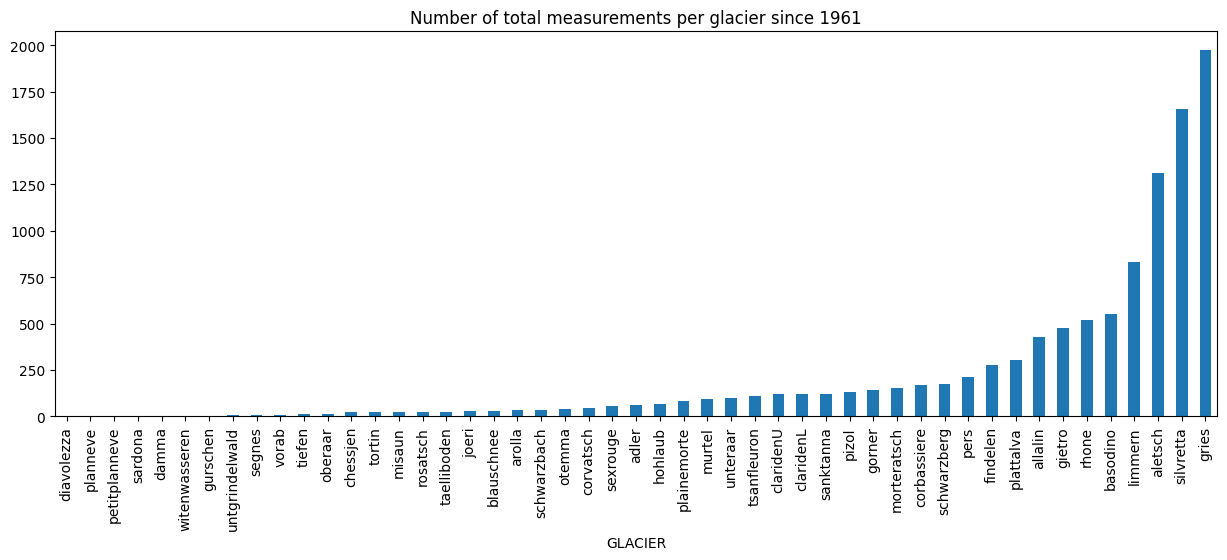

In [16]:
num_gl = df_pmb_60s.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', figsize=(15, 5))
plt.title('Number of total measurements per glacier since 1961')

### 5.1. Merge stakes that are close: 


In [17]:
# clean df_pmb_60s
# Group similar stakes:
df_pmb_60s_clean = pd.DataFrame()
for gl in tqdm(df_pmb_60s.GLACIER.unique(), desc='glacier', position=0):
    print('----------------\n', gl, ':\n----------------')
    df_gl = df_pmb_60s[df_pmb_60s.GLACIER == gl]
    df_gl_cleaned = remove_close_points(df_gl)
    df_pmb_60s_clean = pd.concat([df_pmb_60s_clean, df_gl_cleaned])

# save to csv:
df_pmb_60s_clean.drop(['x', 'y', 'point'], axis=1).to_csv(
    path_PMB_GLAMOS_csv + 'df_pmb_60s_clean.csv', index=False)

# save coordinates:
df_pmb_60s_clean[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
                  'PERIOD']].to_csv(path_PMB_GLAMOS_csv + 'coordinate_60s_clean.csv')

glacier:   0%|          | 0/49 [00:00<?, ?it/s]

adler :
----------------
Number of points dropped: 4
aletsch :
----------------
Number of points dropped: 195
allalin :
----------------
Number of points dropped: 33
arolla :
----------------
Number of points dropped: 0
basodino :
----------------
Number of points dropped: 2
blauschnee :
----------------
Number of points dropped: 4
chessjen :
----------------
Number of points dropped: 19
claridenL :
----------------
Number of points dropped: 121
claridenU :
----------------
Number of points dropped: 119
corbassiere :
----------------
Number of points dropped: 1
corvatsch :
----------------
Number of points dropped: 3
damma :
----------------
Number of points dropped: 0
diavolezza :
----------------
Number of points dropped: 2
findelen :
----------------
Number of points dropped: 6
gietro :
----------------
Number of points dropped: 0
gorner :
----------------
Number of points dropped: 1
gries :
----------------
Number of points dropped: 32
gurschen :
----------------
Number of points d

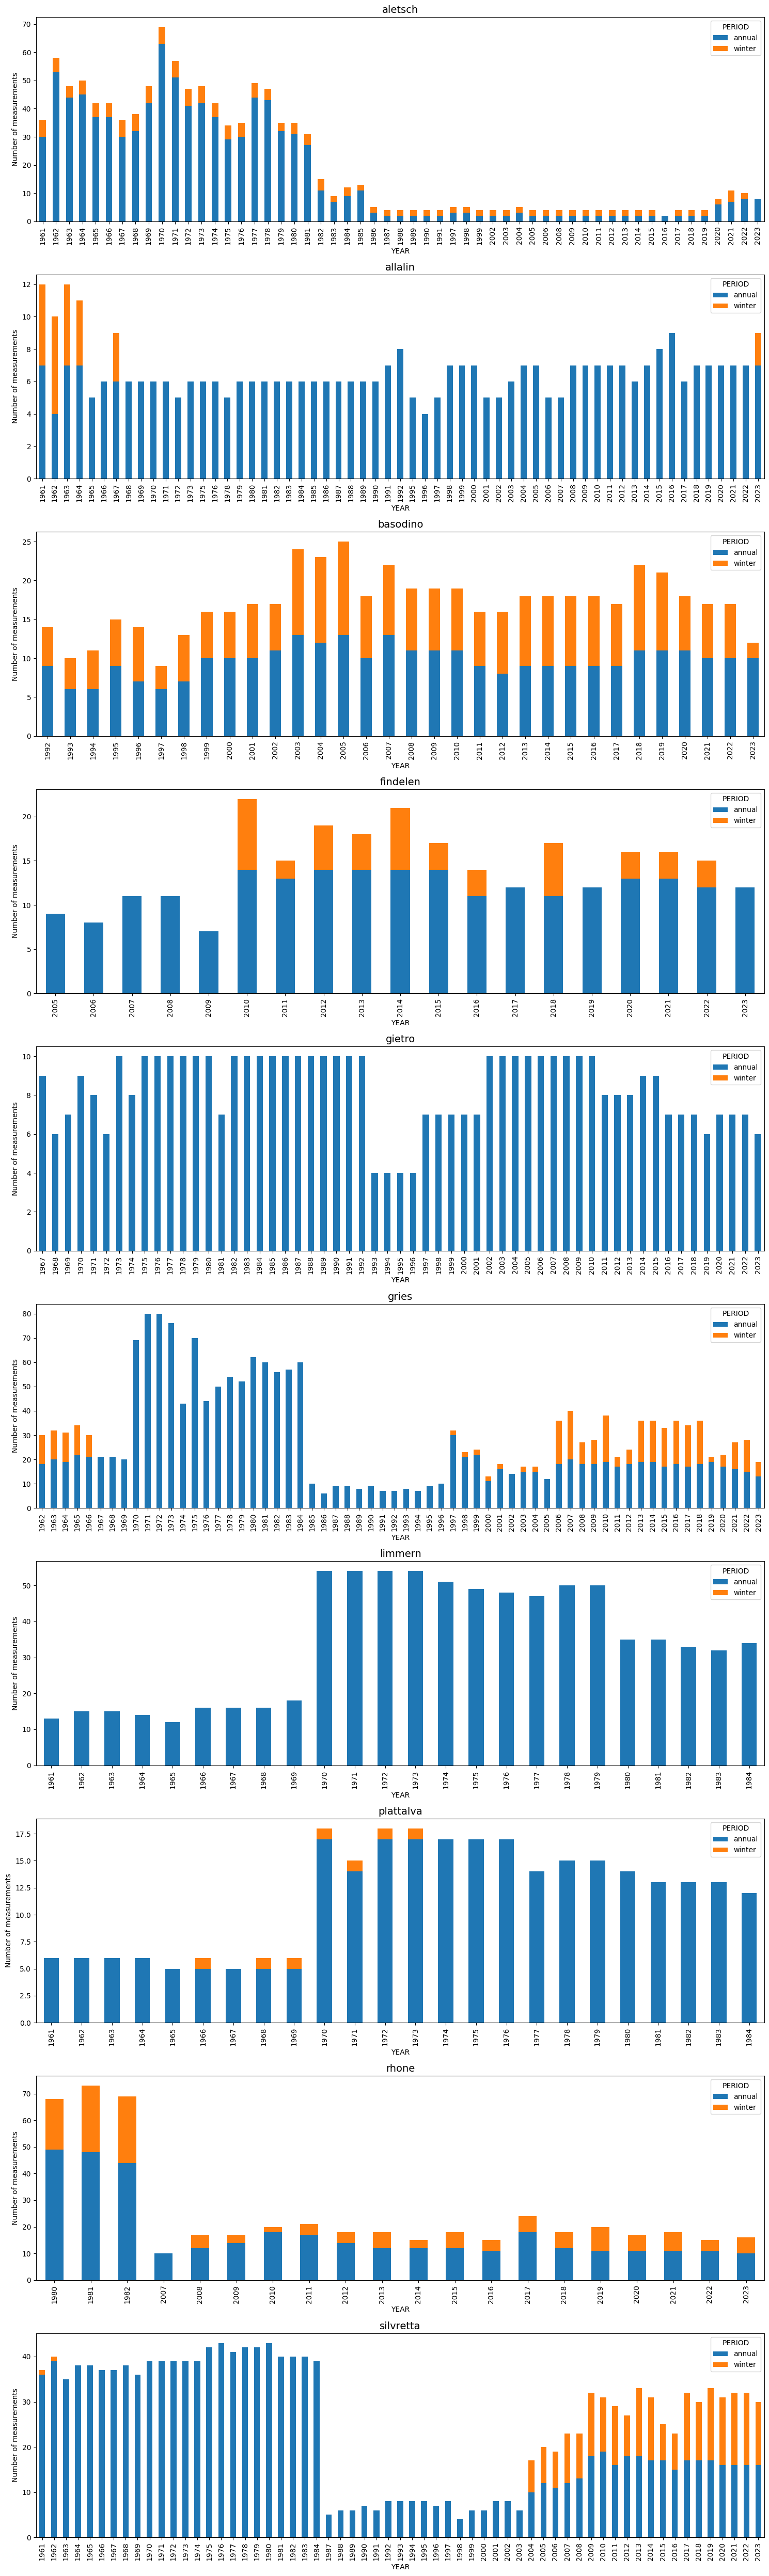

In [18]:
# Number of measurements per glacier per year:
num_gl_yr = df_pmb_60s_clean.groupby(['GLACIER', 'YEAR', 'PERIOD'
                                      ]).size().unstack().reset_index()

# Plot one glacier per column:
big_gl = num_gl[num_gl > 250].index.sort_values()
num_glaciers = len(big_gl)
fig, ax = plt.subplots(num_glaciers, 1, figsize=(15, 5 * num_glaciers))
for i, gl in enumerate(big_gl):
    num_gl_yr[num_gl_yr.GLACIER == gl].plot(x='YEAR',
                                            kind='bar',
                                            stacked=True,
                                            ax=ax[i],
                                            title=gl)
    ax[i].set_ylabel('Number of measurements')
    ax[i].set_title(gl, fontsize=14)
plt.tight_layout()

## Add topographical information from OGGM:

In [19]:
# Provide the column name for the column that has the RGI IDs for each of the stakes
# dataset = mbm.Dataset(data=df_pmb_clean,
#                       region_name='CH',
#                       data_path='')
# # Specify the topographical features of interest
# # Please see the OGGM documentation what variables are available: https://oggm.org/tutorials/stable/notebooks/10minutes/machine_learning.html ('topo', 'slope_factor', 'dis_from_border')
# voi_topographical = ['aspect', 'slope']

# # Retrieve the topographical features for each stake measurement and add them to the dataset
# dataset.get_topo_features(vois=voi_topographical)

# Switch to oggm datapulling notebook:
df_pmb_topo = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv')
print('Number of winter and annual samples:', len(df_pmb_topo))
print('Number of annual samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'winter']))
df_pmb_topo.head(2)

Number of winter and annual samples: 9809
Number of annual samples: 8258
Number of winter samples: 1551


,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId,aspect,slope,dis_from_border,topo
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2592,annual,RGI60-11.02764,4.441578,0.340053,120.0,3039.0
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2502,annual,RGI60-11.02764,4.772892,0.219036,30.0,3091.0


## 6. Monthly format:

In [6]:
# take only annual and not winter MB
data = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv')
data = data[data.PERIOD == 'annual']
# Provide the column name for the column that has the RGI IDs for each of the stakes
dataset = mbm.Dataset(data=data,
                      region_name='CH',
                      data_path=path_PMB_GLAMOS_csv)

# Add climate data:
# Specify the files of the climate data, that will be matched with the coordinates of the stake data
era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'

# Match the climate features, from the ERA5Land netCDF file, for each of the stake measurement dataset
dataset.get_climate_features(climate_data=era5_climate_data,
                             geopotential_data=geopotential_data)
dataset.data.head(2)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2592,annual,...,0.003583,0.003874,0.00389,0.005349,0.007002,0.007252,0.006498,0.008244,2787.508638,-308.999104
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2502,annual,...,0.003583,0.003874,0.00389,0.005349,0.007002,0.007252,0.006498,0.008244,2787.508638,-353.997882


In [7]:
# Specify the short names of the climate variables available in the dataset
vois_climate = ['t2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str']
# voi_topographical = ['aspect', 'slope', 'dis_from_border', 'topo']
voi_topographical = ['aspect', 'slope']

# For each record, convert to a monthly time resolution
dataset.convert_to_monthly(vois_climate=vois_climate,
                           vois_topographical=voi_topographical)
dataset.data.head(2)

,MONTHS,ID,RGIId,POINT_ID,YEAR,N_MONTHS,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,aspect,slope,t2m,tp,slhf,sshf,ssrd,fal,str
0,nov,0,RGI60-11.02764,100,2006,11,7.855896,46.010637,-2592,2787.508638,-308.999104,4.441578,0.340053,265.615025,0.001175,-176999.405490,-243462.317031,7.256997e+06,0.678897,-2.764534e+06
1,dec,0,RGI60-11.02764,100,2006,11,7.855896,46.010637,-2592,2787.508638,-308.999104,4.441578,0.340053,258.801861,0.002283,31280.688874,217670.830543,5.847847e+06,0.818081,-1.811733e+06


In [18]:
df = dataset.data.copy()
df = df[(df.RGIId == 'RGI60-11.01238') & (df.YEAR == 1980)]
df.iloc[:12]

,MONTHS,ID,RGIId,POINT_ID,YEAR,N_MONTHS,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,aspect,slope,t2m,tp,slhf,sshf,ssrd,fal,str
72728,oct,6065,RGI60-11.01238,NN,1980,7,8.384072,46.630520,3600,2386.152737,-743.281951,NaN,NaN,274.615188,0.008568,-843353.374819,-462856.061252,9.071202e+06,0.623152,-2.180636e+06
72729,nov,6065,RGI60-11.01238,NN,1980,7,8.384072,46.630520,3600,2386.152737,-743.281951,NaN,NaN,267.009918,0.006180,-63370.515740,-6801.472571,6.489590e+06,0.784856,-1.923727e+06
72730,dec,6065,RGI60-11.01238,NN,1980,7,8.384072,46.630520,3600,2386.152737,-743.281951,NaN,NaN,265.569589,0.007196,40295.089314,80295.812461,4.691652e+06,0.790104,-1.477446e+06
72731,jan,6065,RGI60-11.01238,NN,1980,7,8.384072,46.630520,3600,2386.152737,-743.281951,NaN,NaN,262.029348,0.004371,42904.521020,40936.981032,5.860454e+06,0.800475,-1.663595e+06
72732,feb,6065,RGI60-11.01238,NN,1980,7,8.384072,46.630520,3600,2386.152737,-743.281951,NaN,NaN,265.436309,0.004191,46700.058047,-20005.725695,1.050150e+07,0.792400,-2.690380e+06
72733,mar,6065,RGI60-11.01238,NN,1980,7,8.384072,46.630520,3600,2386.152737,-743.281951,NaN,NaN,266.933434,0.005462,-97530.348984,-374996.992386,1.360732e+07,0.793968,-2.360336e+06
72734,apr,6065,RGI60-11.01238,NN,1980,7,8.384072,46.630520,3600,2386.152737,-743.281951,NaN,NaN,267.129567,0.003327,-378400.088993,-968426.599149,2.030699e+07,0.790882,-3.207931e+06
72735,may,6065,RGI60-11.01238,NN,1980,7,8.384072,46.630520,3600,2386.152737,-743.281951,NaN,NaN,272.905270,0.004455,-533779.886042,-932368.831001,2.037165e+07,0.724481,-2.933035e+06
72736,oct,6066,RGI60-11.01238,NN,1980,7,8.394486,46.628634,3200,2386.152737,-595.276399,NaN,NaN,274.615188,0.008568,-843353.374819,-462856.061252,9.071202e+06,0.623152,-2.180636e+06
72737,nov,6066,RGI60-11.01238,NN,1980,7,8.394486,46.628634,3200,2386.152737,-595.276399,NaN,NaN,267.009918,0.006180,-63370.515740,-6801.472571,6.489590e+06,0.784856,-1.923727e+06
